# Redes Convolucionales Sep-Dic 2023

Victor Ramos 17-10518

CIFAR-10 es un conjunto de datos ampliamente utilizado en el campo del aprendizaje automático y la visión por computadora. El conjunto de datos CIFAR-10 consta de 60,000 imágenes a color de 32x32 píxeles, divididas en 10 clases diferentes.

Clases: CIFAR-10 consta de 10 clases diferentes, cada una representando una categoría específica de objetos. Las clases son: avión, automóvil, pájaro, gato, venado, perro, rana, caballo, barco y camión.

Imágenes: Cada imagen en CIFAR-10 tiene un tamaño de 32x32 píxeles y es a color, lo que significa que tiene tres canales de color: rojo, verde y azul (RGB). Estas imágenes representan objetos de la vida real en diferentes configuraciones y fondos.

Conjunto de entrenamiento y conjunto de prueba: CIFAR-10 se divide en dos conjuntos principales: el conjunto de entrenamiento y el conjunto de prueba. El conjunto de entrenamiento consta de 50,000 imágenes, mientras que el conjunto de prueba contiene 10,000 imágenes. El conjunto de entrenamiento se utiliza para entrenar modelos de aprendizaje automático, mientras que el conjunto de prueba se utiliza para evaluar el rendimiento del modelo entrenado.

 El objetivo principal en CIFAR-10 es la clasificación de imágenes. Dado una imagen de entrada, el objetivo es determinar a qué clase pertenece dicha imagen

 Para este proyecto se utilizaran las librerias Pytorch, matplotlib y Numpy


In [11]:

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import  f1_score, accuracy_score, confusion_matrix
from google.colab import drive

In [12]:
drive.mount('/content/drive')

%cd /content/drive/MyDrive/CNN Project/Tarea2-Cifar10
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/MyDrive/CNN Project/Tarea2-Cifar10'
/content
data_src/  drive/  sample_data/


In [13]:
transform = transforms.Compose(
    [ToTensor(),
     transforms.Normalize(mean =[0.51, 0.46, 0.40], std =[0.22, 0.22, 0.22])])

batch_size = 5

train_set = torchvision.datasets.CIFAR10(root='./data_src', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data_src', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)

classes = ('Avion', 'Automovil', 'Ave', 'Gato', 'Ciervo', 'Perro', 'Rana', 'Caballo', 'Barco', 'Camion')

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


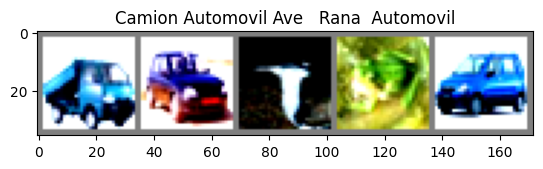

In [15]:
def imagenshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imagenshow(torchvision.utils.make_grid(images))


Modelo de la CNN
PUtilizamos Pytorch, con un modelo de tres capas convolucionales., la primera de 3 canales de entrada y 20 de salida, la segunda de 50 canales de entrada y 40 de salida, y la tercera de 40 canales de entrada y 60 canales de salida, con un filtro 5x5

Se utiliza una capa de pooling luego de cada capa convolucional para reducir el tamaño espacial de la imagen, junco con la funcion flatten para obtener un tensor unidimensional

CrossEntropyLoss es la funcion de perdida y el optimizador sera Stocastic Gradient Descense, con una tasa de aprendizaje de 0.005 y un momentum de 0.80.

In [16]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 40, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(40, 60, 5)
        self.fc1 = nn.Linear(40* 5* 5, 420)
        self.fc2 = nn.Linear(420, 180)
        self.fc3 = nn.Linear(180, 80)
        self.fc4 = nn.Linear(80, 20)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = self.fc4(x)
        return x


CNN1 = CNN1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN1.parameters(), lr=0.005, momentum=0.80)

Entrenamiento de la CNN

Se realiza la iteracion sobre el train_loader, al final de cada epoca se muestra la funcion de perdida, entrenamos durante 10 décadas

In [17]:
array_loss= []
for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = CNN1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if i % 2000 == 1999:
      print('Epoca 'f'[{epoch + 1}] funcion de pérdida: {running_loss / len(train_loader):.4f}')

    array_loss.append((running_loss)/len(train_loader))

print('Entrenamiento finalizado')

Epoca [1] funcion de pérdida: 1.5266
Epoca [2] funcion de pérdida: 1.2216
Epoca [3] funcion de pérdida: 1.0775
Epoca [4] funcion de pérdida: 0.9848
Epoca [5] funcion de pérdida: 0.9210
Epoca [6] funcion de pérdida: 0.8879
Epoca [7] funcion de pérdida: 0.8791
Epoca [8] funcion de pérdida: 0.8984
Epoca [9] funcion de pérdida: 0.9584
Epoca [10] funcion de pérdida: 0.9992
Entrenamiento finalizado


Carga del modelo entrenado en la carpeta 'Training_Model.pt'

In [18]:

PATH = './Training_Model.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': CNN1.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            }, PATH)

Calculo de la precision del modelo

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = CNN1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Precision de la CNN en la prueba de 10000 imagenes:{100 * correct // total} %')

Precision de la CNN en la prueba de 10000 imagenes:61 %


In [22]:
class_name = ['Avion', 'Automovil', 'Ave', 'Gato', 'Ciervo', 'Perro', 'Rana', 'Caballo', 'Barco', 'Camion']
correct_predictions = [0] * len(class_name)
total_images = [0] * len(class_name)

for data in test_loader:
    images, labels = data
    outputs = CNN1(images)
    _, predicted = torch.max(outputs.data, 1)
    for i in range(len(labels)):
        label = labels[i]
        prediction = predicted[i]
        if label == prediction:
          correct_predictions[label] += 1
        total_images[label] += 1


class_accuracy = [100*correct_predictions[i] / total_images[i] for i in range(len(class_name))]

for key in range(len(class_name)):
    print(f'Precision de la clase {class_name[key]} en la prueba de 10000 imagenes:{class_accuracy[key]} %')

Precision de la clase Avion en la prueba de 10000 imagenes:75.6 %
Precision de la clase Automovil en la prueba de 10000 imagenes:76.3 %
Precision de la clase Ave en la prueba de 10000 imagenes:50.8 %
Precision de la clase Gato en la prueba de 10000 imagenes:37.1 %
Precision de la clase Ciervo en la prueba de 10000 imagenes:46.7 %
Precision de la clase Perro en la prueba de 10000 imagenes:47.5 %
Precision de la clase Rana en la prueba de 10000 imagenes:74.0 %
Precision de la clase Caballo en la prueba de 10000 imagenes:61.9 %
Precision de la clase Barco en la prueba de 10000 imagenes:65.0 %
Precision de la clase Camion en la prueba de 10000 imagenes:77.6 %


Mapa de Calor

Para la primera capa convolucional el mapa de calor nos permite visualizar cuales son las regiones de activacion mas importantes



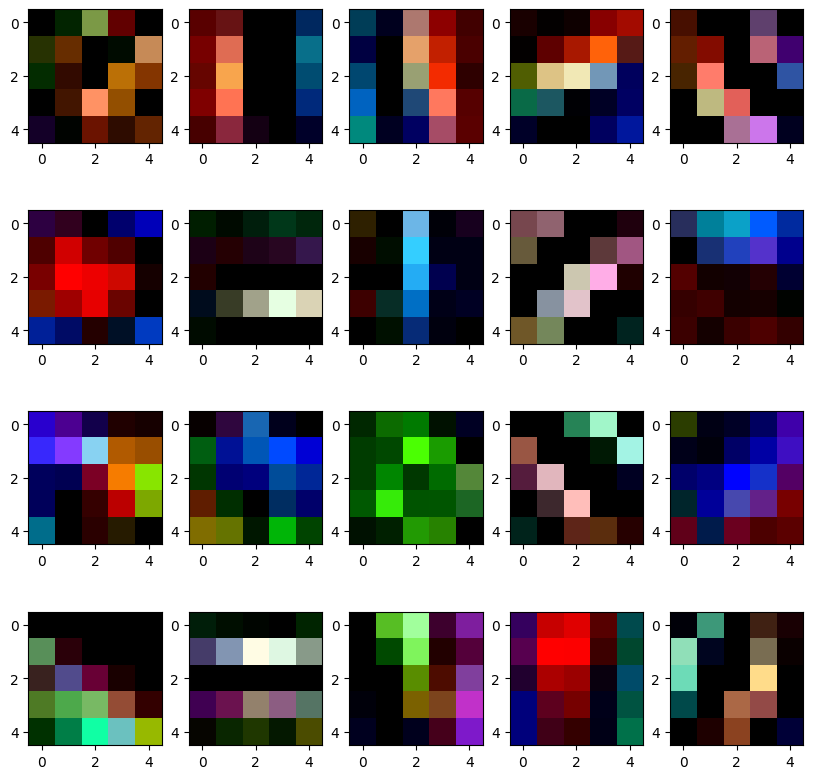

In [24]:

weight1 = []

for x in CNN1.state_dict()['conv1.weight']:
      w1 = np.transpose(x)
      w1 = w1/w1.max()
      w1 = np.clip(w1, 0, 1)
      weight1.append(w1)

figure, axes = plt.subplots(nrows=4, ncols=5, figsize =(10,10))

for a, b in zip(axes.ravel(), range(20)):
  nimage = np.random.randint(len(weight1))
  a.imshow(weight1[b])


Para la segunda capa, podemos observar que los patrones de la zona de activacion generalmente se encuentran en las esquinas de la imagen



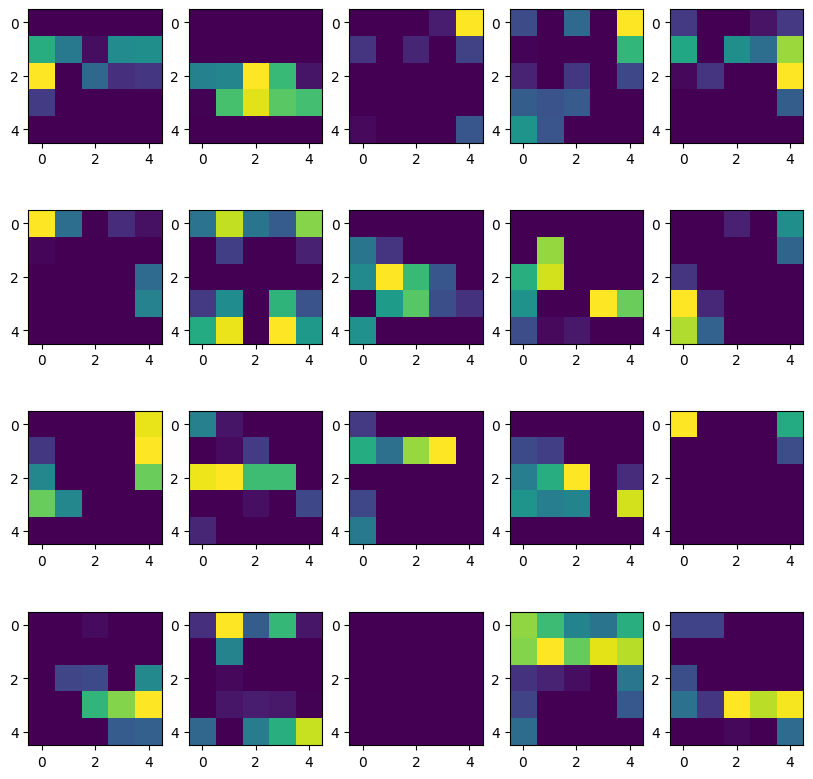

In [25]:
weight2 = []
for x in CNN1.state_dict()['conv2.weight']:
  for w in x:
      w2 = w
      w2 = w2/w2.max()
      w2 = np.clip(w2, 0, 1)
      weight2.append(w2)

figure, axes = plt.subplots(nrows=4, ncols=5, figsize =(10,10))

for a, b in zip(axes.ravel(), range(30)):
  nimage = np.random.randint(len(weight2))
  a.imshow(weight2[b])

#Conclusion#

Al entrenar el modelo, se logro una mejora de este de un 50% inicialmente a un 71%, esto al realizar cambios en la arquitectura de la red.

Se puede observar que la precision por clases presenta un numero aceptable. Esta precision puede aumentar si se aumenta el numero de capas de la red

Los cambios realizados tuvieron como consecuencia un aumento considerable en el tiempo de entrenamiento, llegando a un tiempo cercano a los 40min al agregar la tercera capa